# Imaging


Mean lifetime
=============


# Formats
Content unclear => ask Suren

pg4 file
========
Parameters from data?
---------------------
Y pixel:    row index
X pixel:    column index
Green Count Rate (KHz): Number of green photons divided by pixel duration
Number of Photons (green): Number of green photons
Pixel Number: (Y Pixel) * (Number of Y Pixels) + X Pixel
Parameters from fit?
--------------------
Number of Photons (fit window) (green)
tau (green)	gamma (green)
r0 (green)
rho (green)
BIFL scatter fit? (green)
2I*: P+2S? (green)
rS (green)
rE (green)
2I* (green)
Ng-p-all    Number (green) of photon in parallel channel
Ng-s-all    Number (green) of photon in perpendicular channel
Ng-all      Number of (green) photons

pr4 file
========
Parameters from data?
---------------------
Y pixel:    row index
X pixel:    column index
Red Count Rate (KHz): Number of red photons divided by pixel duration
Number of Photons (red): Number of green photons
Pixel Number: (Y Pixel) * (Number of Y Pixels) + X Pixel
Parameters from fit?
--------------------
Number of Photons (fit window) (red)
tau gesamt (red)
gamma (red)
Chi2 (red)
rS (red)
rE (red)
rC (red)
Nr-p-all	Number of (red) photons in parallel channel
Nr-s-all	Number of (red) photons in perpendicular (senkrecht) channel
Nr-all	Number of (red) photons





Overview
========
In confocal laser scanning microscopy (CLSM) the sample is scanned by a laser beam
either by moving the sample over a parked (fixed) laser beam (stage scanning)
or by deflecting the laser and moving the position of the exciting on a fixed
sample (laser scanning). In both cases, the position of the detection volume
within the sample needs to be saved in the recorded TTTR event stream. In the
section `Theory` the basics of CLSM data are described. In the section
`Image construction` basic python functions are used to create an CLSM image
using ``TTTR`` objects. In the section `CLSMImage` it is explained how to use
``tttrlib``'s C++ interface to efficiently create CLSM images and different
`CLSM representations`, e.g., intensity images, mean micro time images are
presented with a brief application and example source-code. Moreover, for an CLSM
image the resolution is :ref:`estimated<frc-image>`) by Fourier
Ring Correlation and it is described how CLSM markers can be analyzed only given
the photon stream using data from an Leica SP8 a :ref:`example<LeicaSp8Marker>`.

Applications
============
Representations
---------------
The are several ways how the data contain in CLSM images can be represented and
analyzed. For instance, images can be computed where every pixel contains an average
fluorescence lifetime or an intensity. A few representations for CLSM data and
scripts how to generate these representations are outlined here.

#.. plot:: ../examples/imaging/imaging_representations.py

The figure displayed above corresponds to a live-cell FLIM measurement of eGFP. The
fluorescent label eGFP is often used as an donor fluorophore in FRET experiments.
In the image shown above, eGFP was measured in the absence of FRET. The intensity
image shows a non uniform intensity in the cell. However, an image of the mean
arrival time reveals as expected a uniform distribution. Inspecting the fluorescence
decay curve of the corresponding image reveals a fluorescence decay that is not
curved and hence likely single exponential.

Below a few applications are presented.

Intensity
---------
An intensity image of a ``CLSMImage`` instance that has been filled with photons
can be created by counting the number of photons in each pixel. This can either
be accomplished by iterating over the frames, lines, and pixels or by using the
method ``fill_pixels`` of a ``CLSMImage`` instance.

.. code-block::python

    import tttrlib
    tttr_data = tttrlib.TTTR('./data/pq/ht3/PQ_HT3_CLSM.ht3', 'HT3')
    channels = (0, 1)
    reading_parameter = {
        "tttr_data": tttr_data,
        "marker_frame_start": [4],
        "marker_line_start": 1,
        "marker_line_stop": 2,
        "marker_event_type": 1,
        "n_pixel_per_line": 256, # if zero n_pixel_per_line = n_lines
        "reading_routine": 'default',
        "fill": True,
        "channels": channels
    }
    clsm_image = tttrlib.CLSMImage(**reading_parameter)

    # option 1
    n_frames = clsm_image.n_frames
    n_lines = clsm_image.n_lines
    n_pixel = clsm_image.n_pixel
    intensity_image = np.zeros((n_frames, n_lines, n_pixel))
    for frame_idx, frame in enumerate(clsm_image):
        for line_idx, line in enumerate(frame):
            for pixel_idx, pixel in enumerate(line):
                n_photons = len(pixel.tttr_indices)
                intensity_image[frame_idx, line_idx, pixel_idx] = n_photons

    # option 2 - using the C++ method
    intensity_image = clsm_image.fill_pixels(tttr_data, channels)


Iterating large images and multiple pixels in python generates a large overhead.
Hence, the recommended procedure that is equivalent to the code above to generate
intensity images is the second option.

Mean micro time
---------------
To create an image of the mean micro times in a pixel the method ``get_mean_micro_time_image`` of a
``CLSMImage`` instance has to be provided with a ``TTTR`` object the method uses
the tttr indices of the photons stored in the ``CLSMPixel`` objects to look-up the
micro times of the respective photons. The micro times of every pixel are average
to yield an average arrival time of the photons in a pixel.

.. code-block::python

    tttr_data = tttrlib.TTTR('./data/pq/ht3/PQ_HT3_CLSM.ht3', 'HT3')
    channels = (0, 1)
    reading_parameter = {
        "tttr_data": tttr_data,
        "marker_frame_start": [4],
        "marker_line_start": 1,
        "marker_line_stop": 2,
        "marker_event_type": 1,
        "n_pixel_per_line": 256, # if zero n_pixel_per_line = n_lines
        "reading_routine": 'default',
        "fill": True,
        "channels": channels
    }
    clsm_image = tttrlib.CLSMImage(**reading_parameter)

    minimum_number_of_photons = 3
    image_mean_micro_time = clsm_image.get_mean_micro_time_image(
        tttr_data,
        minimum_number_of_photons=minimum_number_of_photons
    )
    n_frames, n_lines, n_pixel = image_mean_micro_time.shape
    n_frames == 40 # True
    n_lines == 256 # True
    n_pixel == 256 # True

The pixel-wise average arrival time over the frames in a CLSMImage object is
computed by the method ``get_mean_micro_time_image`` when the optional parameter
``stack_frames`` is set to True.

.. code-block::python

    image_mean_micro_time_stack = clsm_image.get_mean_micro_time_image(
        tttr_data,
        minimum_number_of_photons=minimum_number_of_photons,
        stack_frames=True
    )
    n_frames, n_lines, n_pixel = image_mean_micro_time_stack.shape
    n_frames == 1  # True
    avg_2 = image_mean_micro_time.mean(axis=0) # do not use such average
    np.allclose(image_mean_micro_time_stack, avg_2) # False


.. note::
    The average over a stack of average arrival times and the stacked and
    averaged arrival times differ. If the average arrival time is computed
    for every frame and then the arrival times are averaged, the number of
    photons that resulted in the average is not considered. Thus, the two
    averages in the code-block displayed above differ.

Average fluorescence lifetime
-----------------------------
The moments of the fluorescence intensity decay can be directly computed also
considering the instrument response function (IRF) :cite:`isenberg_studies_1973`.

#.. plot:: ../examples/imaging/imaging_mean_tau.py

The shown example computes for every pixel a mean fluorescence lifetime considering
the IRF that is provided as a ``tttrlib.TTTR`` object.

Phasor
------
The phasor method’s is a model free analysis that has certain advantages
over conventional nonlinear curve fitting, which is computationally-intensive and
can be sensitive to potential inaccuracies due to correlations between computed
terms. The phasor analysis provides a robust approach to investigate variations
in fluorescence lifetime measurements .

#.. plot:: ../examples/imaging/imaging_phasor.py

Top phasor without instrument response function (IRF) correction. Bottom phasor
with IRF correction.

Fluorescence decay histograms
-----------------------------
The micro times of the photons in every pixel can be binned to yield a fluorescence
decay histogram for every pixel in the CLSM image. This is implemented in the method
``get_fluorescence_decay_image`` of ``CLSMImage`` objects.

.. code-block::python

    image_decay = clsm_image.get_fluorescence_decay_image(
        tttr_data,
        stack_frames=False
    )
    n_frames, n_lines, n_pixel, n_micro_time_bins = image_decay.shape
    n_frames == 40  # True
    n_micro_time_bins == 32768
    image_decay = clsm_image.get_fluorescence_decay_image(
        tttr_data,
        stack_frames=True,
        micro_time_coarsening=256
    )
    n_frames, n_lines, n_pixel, n_micro_time_bins_2 = image_decay.shape
    n_micro_time_bins_2 == n_micro_time_bins // 256
    n_frames == 1  # True

When the optional parameter ``stack_frames`` is set to True (the default value is
False). The optional parameter ``micro_time_coarsening`` is used to decrease the
resolution of the fluorescence decay histogram. The default value of ``micro_time_coarsening``
is 1 and the micro time resolution is used as is. A value of 2 decreases the micro
time resolution by a factor of 2.

.. note::
    A four dimensional array may consume a considerable amount of memory. Thus,
    use appropriate values for the parameters of ``get_fluorescence_decay_image``
    to reduce the memory consumption.

Pixel averaged decays
---------------------
Using selection masks the signal to noise of the fluorescence decays can be greatly
improved to allow for a detailed analyis. Here it is briefly outlined, how pixels
are selected and fluorescence decays of these pixel sub-populations can be created.

#.. plot:: ../examples/imaging/imaging_pixel_masks.py

Pixels are selected by a pixel mask, i.e., arrays of the same size as a CLSM image.
The micro times of the photons associated to the selected pixels can be binned into
fluorescence decay histograms. This way, fluorescence decays of regions of interest
(ROIs) can be created. ROIs can be defined by normal bitmap images. A different ROI
can be used for each frame in an CLSM image.

.. code-block::python

    from matplotlib.pyplot import imread
    import tttrlib
    import numpy as np

    tttr_data = tttrlib.TTTR('./data/pq/ht3/PQ_HT3_CLSM.ht3', 'HT3')
    channels = (0, 1)
    reading_parameter = {
        "tttr_data": tttr_data,
        "marker_frame_start": [4],
        "marker_line_start": 1,
        "marker_line_stop": 2,
        "marker_event_type": 1,
        "n_pixel_per_line": 256, # if zero n_pixel_per_line = n_lines
        "reading_routine": 'default',
        "fill": True,
        "channels": channels
    }
    clsm_image = tttrlib.CLSMImage(**reading_parameter)
    mask = imread("./data/aux/PQ_HT3_CLSM_MASK.png").astype(np.uint8)
    selection = np.ascontiguousarray(
        np.broadcast_to(
            mask,
            (clsm_image.n_frames, clsm_image.n_lines, clsm_image.n_pixel)
        )
    )
    kw = {
        "tttr_data": tttr_data,
        "selection": selection,
        "selection": selection,
        "tac_coarsening": 16,
        "stack_frames": True
    }
    decay = clsm_image.get_average_decay_of_pixels(**kw)
    decay.shape == (1, 2048)
    kw["stack_frames"] = False
    decay_2 = clsm_image.get_average_decay_of_pixels(**kw)
    decay_2.shape == (40, 2048)

The decays of the different frames can be stacked by setting the parameter ``stack_frames``
to True.

.. note::
    To keep the memory consumption low, we use only 8 bit per element in the selection
    mask.

Correlation function
--------------------
Every pixel is defined by a list of TTTR indices. To these indices a macro time
and micro time are associtate. Hence, correlation functions can be computed.

.. _frc-image:


Image correlation spectroscopy
------------------------------
Fluorescence fluctuation spectroscopy can be combined with fluorescence imaging.
Image correlation spectroscopy (ICS) allows to extracted molecular properties from
microscopy images :cite:`petersen_quantitation_1993`. There are many flavours of
ICS. For conventional CLSM imaging the most relevant is raster image correlation
spectroscopy (RICS) that can be used to study the molecular translational diffusion
constant (D), absolute concentration (c), and intermolecular binding constants of
diffusive molecules :cite:`digman_measuring_2005` :cite:`digman_fluctuation_2005`
:cite:`digman_detecting_2009`. The static method ``CLSMImage.compute_ics`` allows
to correlate ``CLSMImage`` objects and stacks of images for ICS analysis.

#.. plot:: ../examples/imaging/imaging_ics_tttrlib.py

The figure above displays an image and the corresponding image correlation for a
region of interest (ROI) that is highlighted by a red square. ``tttrlib`` supports
squared ROIs that can be background corrected. However, in general ICS can be
applied to arbitrarily shaped ROIs is :cite:`hendrix_arbitrary-region_2016`.

With a few lines of python code the computed correlations can be analyzed and
fitted to yield diffusion coefficients and concentrations.

#.. plot:: ../examples/imaging/imaging_ics_fit.py

The figure above displays an image, the corresponding ICS, and the weighted residuals
of the model and the analysis results.

.. note::
    For RICS the line durations (line time) and the pixel duration (pixel time)
    need to be known. These parameters can be
    setup. Moreover, some setup configurations use "photons" event types to record
    special events. Different microscopes may use different markers. For common
    microscopes such as the Leica SP5 and Leica SP8 ready-to-use image processing
    routines are provided.


Autocorrelations

Spatiotemporal ICS (STICS)


Cross-correlations (


Image markers
=============
General
-------
The position of the laser in the TTTR event stream is encoded by injecting
markers into the event stream the report on the laser position. Some manufactures
present these markers as special ""events"" that are distinguished from normal
photon events. Some manufacturers use the same routing channel numbers for markers
and for photon detection channels. To distinguish photons from markers,``TTTR``
objects present for every event an additional event type specifier (see
:doc:`tttr_objects`).

The position of the laser on the sample is mostly defined by the following markers

.. highlights::

    1. A frame marker
    2. A line start marker
    3. A line stop marker

The line start and the line stop marker define a *valid* region of the image. In
confocal laser scanning microscopy (CLSM) the laser beam is usually repositioned
between the line stop and the line start marker. The detectors are usually switched
on in this period and register how the laser is fast repositioned on the sample.
The TTTR stream can be also processed outside of this valid region. However, then
the pixel sizes may not be uniform.

The assignment of the markers to channels depends on the configuration of the
microscope. Below it is briefly outlined how these markers can be assigned to
channels.

Below a typical traces of channel numbers for special events are shown.

#.. plot:: ../examples/imaging/imaging_special_markers.py

To the top a longer trace of special events channel numbers is shown. As can be
seen by inspecting the traces of special events, channel number 4 is followed by
an interleaved sequence of channel number 1 and channel number 2. This identifies
channel 4 as frame number and channel 1 and 2 as, line start and line stop,
respectively. As is shown for the end of the special event channel trace, the last
frame marker is followed by an incomplete frame. This is not uncommon. Hence, the
photons registered following the last frame number should be rejected, as they
would result in an incomplete image.

The markers markers and the photons between the markers need to be analyzed to
form an image.


CLSMImage
=========
Data structure
--------------
CLSM recordings are not imaging data in a classical sense. There is no strict definition
of a pixel and in pulsed time-resolved (tr) experiments that can have multiple lasers
(Pulsed Interleaved Excitation, PIE) and multiple detectors that resolve the polarization
and the spectral ranges of the photons (Multiparameter Fluorescence Detection, MFD).
Hence, a standard imaging data structure is not a very handy format to operate on
time-resolved PIE-MFD CLSM data. Moreover, CLSM data can encode multiple frames,
either from time-series or 3D stacks.

``tttrlib`` handles CLSM images by the ``CLSMImage`` class. The ``CLSMImage`` class
implements a data structure for CLSM images that can be used to query photons of
pixels in frames, lines, and pixels of CLSM data. For that, ``CLSMImage`` processes
``TTTR`` objects. The photons contained in the ``TTTR`` object are grouped based on
the specified markers. After reading the TTTR data into a ``TTTR`` object, the
``TTTR`` object is used to create a new ``CLSMImage`` object.

Use Python and C/C++
--------------------
As was pointed out above based on a few lines of Python source code (see
:ref:`Image scanning:Confocal laser scanning:Theory`) to construct an
image

    1. the frame marker
    2. the line start marker
    3. the line stop marker
    4. the detector channel numbers
    5. the number of pixels per scanning line

need to be specified. Based on these parameters, the indices of the photons in the
TTTR data stream are assigned to frames, lines, and pixels. When creating a ``CLSMImage``
object with a ``TTTR`` object that contains the photon stream a set of ``CLSMFrame``,
``CLSMLine``, and ``CLSMPixel`` objects are create.

.. code-block:: python

    from __future__ import print_function
    import tttrlib
    import numpy as np
    import pylab as p

    data = tttrlib.TTTR('./examples/pq/ht3/PQ_HT3_CLSM.ht3', 1)

    frame_marker = 4
    line_start_marker = 1
    line_stop_marker = 2
    event_type_marker = 1
    pixel_per_line = 256
    image = tttrlib.CLSMImage(
        data,
        frame_marker,
        line_start_marker,
        line_stop_marker,
        event_type_marker,
        pixel_per_line,
        reading_routine='default'
    )


.. note::
    In the example above the reading routine is specified to the default (=0). If
    no reading routine is specified the ``CLSMImage`` class uses the channel number
    of an event to identify line start/stops and frame marker. In Leica SP8 PTU files
    the micro time of an photon events encodes the type of the event. Here, a different
    reading routine needs to be specified.

The last parameter (here 0) specifies the reading routine (parameter = ``reading_routine``)
for the line and frame markers. The supported marker types are shown in the table
below.

.. _marker-types:
.. table:: Table of selections for reading routines for CLSMImages
    :widths: auto

    +--------------------------+--------+----------------+
    | Line, Framer marker type | Option                  |
    +==========================+========+================+
    |Default (routing channel) |default                  |
    +--------------------------+-------------------------+
    |Leica SP8 (micro time)    |SP8                      |
    +--------------------------+-------------------------+
    |Leica SP5 (micro time)    |SP5                      |
    +--------------------------+-------------------------+


As illustrated by the code shown below, every ``CLSMImage`` object may contain multiple
``CLSMFrame`` objects , every ``CLSMFrame`` contain a set of ``CLSMLine`` objects,
and every ``CLSMLine`` object contains multiple ``CLSMPixel`` objects. The number
of ``CLSMPixel`` objects per line is specified upon instantiation if the ``CLSMImage``
object (see code example above). The ``CLSMFrame``, ``CLSMLine``, and the ``CLSMPixel``
classes derive from the ``TTTRRange`` class and provide access to the associated
TTTR indices that mark the beginning and the end of the respective object via the
function ``get_start_stop`` (see example below).


.. code-block:: python

    frames = image.get_frames()
    frame = frames[0]

    print("Frame")
    print("-----")
    print("start, stop: ", frame.get_start_stop())
    print("start time, stop time: ", frame.get_start_stop_time())
    print("duration: ", frame.get_duration())

    lines = frame.get_lines()
    line = lines[0]
    print("Line")
    print("-----")
    print("start, stop: ", line.start_stop
    print("start time, stop time: ", line.get_start_stop_time())
    print("duration: ", line.get_duration())

    pixels = line.get_pixels()
    pixel = pixels[100]
    print("Pixel")
    print("-----")
    print("start, stop: ", pixel.get_start_stop())
    print("start time, stop time: ", pixel.get_start_stop_time())
    print("duration: ", pixel.get_duration())


Object of the ``CLSMImage`` class store the frame, line, and pixel location of the
TTTR data stream that was used to create the ``CLSMImage`` object. Next, to determine
images, the detection channels of interest need to be specified using the method
``fill_pixels``. The method ``fill_pixels`` populates the

.. note::
    The pixels are not filled with start and stop indices and associated start and
    stop times, as the channels of the image have not been defined.

To fill the pixels, it has to be defined, which detection channels are used. Next,
the pixels can be filled. When filling the pixels, to every pixel a start and stop
time in the TTTR data stream is associated.

.. code-block:: python

    channels = (0, 1)
    image.fill_pixels(data, (0, 1))

    print("Pixel")
    print("-----")
    print("start, stop: ", pixel.get_start_stop())
    print("start time, stop time: ", pixel.get_start_stop_time())
    print("duration: ", pixel.get_start_stop_time())

    image_intensity = image.intensity
    image_decay = image.get_fluorescence_decay_image(data, 32)

    p.imshow(image_intensity.sum(axis=0))
    p.show()

    p.semilogy(image_decay.sum(axis=(0,1,2)))
    p.show()


To yield the mean time between excitation and detection of fluorescence the method
``get_mean_micro_time_image`` can be used. The example shown below shows the counts per
pixel for all frames (top, left), the counts per pixel for frame number 30 (top,
right), and the mean time between excitation and detection of fluorescence (bottom,
left). The function ``get_mean_micro_time_image`` takes in addition to the TTTR data an
argument that discriminates pixels with less than a certain amount of photons (below
3 photons). As can be seen by this analysis, the mean time between excitation and
detection of fluorescence is fairly constant over the cell, while the intensity
varies in this particular sample.

For more detailed analysis the fluorescence decays contained in the 4D image (frame,
x, y, fluorescence decay) returned by ``get_fluorescence_decay_image`` can be used,
e.g., by analyzing fluorescence decay histograms. A full example that generates a
fluorescence decay containing all photons of the 30 frames is shown below.

Creating CLSM images
--------------------
General reading framework
^^^^^^^^^^^^^^^^^^^^^^^^^
When a new ``CLSMImage`` object is created, the markers are processed. If the
number of lines is set to zero the number of pixels per line is set to the number
of lines. To create CLSM image the TTTR object needs to be provided in addition
to the markers. The markers can be manually specified.

.. code-block:: python

    filename = './test/data/imaging/pq/ht3/pq_ht3_clsm.ht3'
    data = tttrlib.TTTR(filename, 'HT3')
    reading_parameter = {
        "marker_frame_start": [4],
        "marker_line_start": 1,
        "marker_line_stop": 2,
        "marker_event_type": 1,
        "n_pixel_per_line": 256, # if zero n_pixel_per_line = n_lines
        "reading_routine": 'default'
    }
    clsm_image = tttrlib.CLSMImage(
        tttr_data=data,
        **reading_parameter
    )

The frames in a ``CLSMImage`` object are ``CLSMFrame`` objects. Lines in frame are
``CLSMLine`` objects and pixels in lines are ``CLSMPixel`` objects. The ``CLSMFrame``,
``CLSMLine``, and the ``CLSMPixel`` class inherent from the ``TTTRRange`` class
(see :ref:`TTTR-Objects:TTTR ranges`). Briefly, TTTRRange objects keep track of the
photon indices in a given range.

After a ``CLSMImage`` object is created without specifying the channels, it is an
container that keeps track of the beginning and end of the frames, lines. The pixels
in the lines are empty and do not refer to photon indices. The frames, lines, and
pixels of a ``CLSMImage`` object can be accessed by their index.

.. code-block:: python

    clsm_image = tttrlib.CLSMImage(
        tttr_data=data,
        **reading_parameter
    )
    frame = clsm_image[0]
    line = frame[100]
    pixel = line[100]
    len(pixel.tttr_indices) == 0 # True

The indices of the photons in a pixel can be accessed by the attribute ``tttr_indices``.
To fill the pixels, the channel of interest needs to be specified by its channel
number.

.. code-block:: python

    clsm_image.fill_pixels(
        tttr_data=data,
        channels=[0]
    )
    len(pixel.tttr_indices) == 0 # False

When filling the pixels with photons that are identified via their channel number
in the tttr data, multiple channels can be specified.

Alternatively, the channels can be specified when a ``CLSMImage`` object is created.

.. code-block:: python

    filename = './test/data/imaging/pq/ht3/pq_ht3_clsm.ht3'
    reading_parameter = {
        "tttr_data": tttrlib.TTTR(filename, 'HT3')
        "marker_frame_start": [4],
        "marker_line_start": 1,
        "marker_line_stop": 2,
        "marker_event_type": 1,
        "n_pixel_per_line": 256, # if zero n_pixel_per_line = n_lines
        "reading_routine": 'default',
        "fill": True,
        "channels": [0, 2]
    }
    clsm_image = tttrlib.CLSMImage(**reading_parameter)
    len(pixel.tttr_indices) != 0 # True


Here, the optional parameter "channels" in combination with the optional parameter
"fill" instruct the constructor of ``CLSMImage`` to fill the pixels with events that
are identified by the routing channel numbers 0 and 2.

After filling the pixels with tttr indices (photon indices) the CLSM container
can be used to create different representations of the data. A representation
of the data is for instance an intensity image that counts the photons in each pixel,
a mean micro time image, a 3D map that contains a fluorescence decay histogram at
every pixel, or an 3D map that contains a correlation function that is computed over
the photons in each pixel.

Reading PTU files
^^^^^^^^^^^^^^^^^
`PicoQuant <https://www.picoquant.com/>`_ PTU files can contain additional image
information in the file file header that inform the frame marker, the line marker.
This data can be accessed by ``data`` attribute of the ``TTTR``'s object header.
Thus, for ``CLSMImage`` instances of PTU files can be created by

.. code-block:: python

    tttr_data = tttrlib.TTTR('./data/imaging/pq/Microtime200_HH400/beads.ptu', 'PTU')
    clsm = tttrlib.CLSMImage(tttr_data)


The PTU files of the Leica SP5 and the Leica SP8 use a non-standard way of encoding
line markers. Thus the reading routing needs to be specified. For other CLSM PTU
data ``CLSMImage`` instances can be directly created

.. code-block:: python

    tttr_data = tttrlib.TTTR('./data/imaging/leica/sp5/LSM_1.ptu', 'PTU')
    clsm_image = tttrlib.CLSMImage(tttr_data, reading_routine = 'SP5')

PTU files can also be opened by manually providing the marker parameters as
described above.

Copying CLSMImage instances
---------------------------
A new ``CLSMImage`` object can be created using an existing ``CLSMImage`` object
as a template.

.. code-block:: python

    tttr_data = tttrlib.TTTR('./test/data/imaging/pq/ht3/pq_ht3_clsm.ht3', 'HT3')
    reading_parameter = {
        "tttr_data": tttr_data,
        "marker_frame_start": [4],
        "marker_line_start": 1,
        "marker_line_stop": 2,
        "marker_event_type": 1,
        "n_pixel_per_line": 256, # if zero n_pixel_per_line = n_lines
        "reading_routine": 'default',
        "fill": True,
        "channels": [0, 2]
    }
    clsm_image_1 = tttrlib.CLSMImage(**reading_parameter)
    clsm_image_2 = tttrlib.CLSMImage(source=clsm_image_1, fill=True)

When creating a ``CLSMImage`` object using another ``CLSMImage`` object as a source
the frames, lines, and pixels are copied. When the optional parameter `fill` is
set the tttr indices of the photons are copied as well.

Exporting as TIFF
-----------------
All representations of the FLIM data are `numpy <https://numpy.org/>`_ arrays that
can be written of standard image data formats for instance using the input/output
functionality of `OpenCV <https://opencv.org/>`_ or the library `tiffile <https://pypi.org/project/tifffile/>`_

The sample code below opens a PTU dataset from a Leica SP5 and writes an intensity
image to a TIFF image stack.

.. code-block:: python

    import tifffile
    tttr_data = tttrlib.TTTR('./data/imaging/leica/sp5/LSM_1.ptu', 'PTU')
    clsm_image = tttrlib.CLSMImage(tttr_data, reading_routine = 'SP5')
    output_file = 'intensity_image.tif'
    img_stack = clsm.intensity
    img_stack = np.array([i.T for i in img_stack])
    img_stack *= (2 ** 16 - 1) // np.max(img_stack)
    img_stack = img_stack.astype(dtype=np.uint16)
    with tifffile.TiffWriter(output_file, imagej=True) as tif:
        tif.save(img_stack)

Other representations can be saved accordingly as TIFF images.

.. note::

    Many representations use float, doubles, or long integers (64bit) that are
    often not fully supported by standard image formats. Thus, make sure that the
    images are properly scaled and quantized before saving.



==============================
Image correlation spectroscopy
==============================


# Decay moments

In [3]:
tttr_green_prompt

tttrlib.TTTR("/home/tpeulen/dev/tttrlib/doc/modules/../../tttr-data/imaging/zeiss/eGFP_bad_background/eGFP_bad_background.ptu", "PTU")

Nbr. Photons:  31005074.0
background_fraction: 0.18311995481771795


/opt/tljh/user/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/tljh/user/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


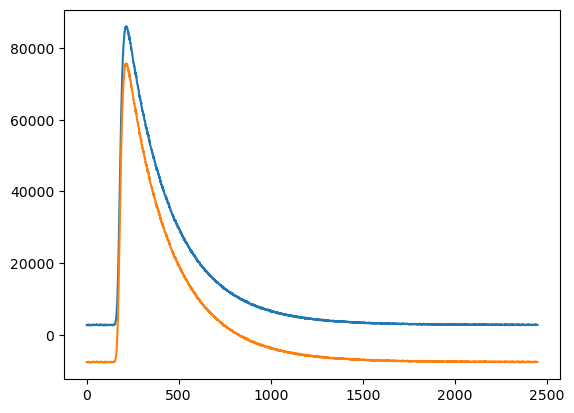

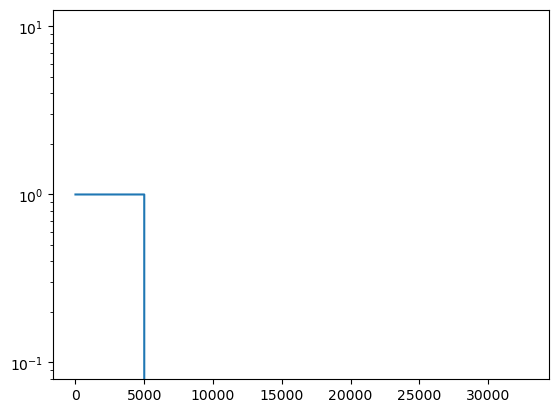

/tmp/ipykernel_1631539/3861523619.py:31: RuntimeWarning: divide by zero encountered in log
  lg_sg_sr = np.log(masked_green / masked_red)


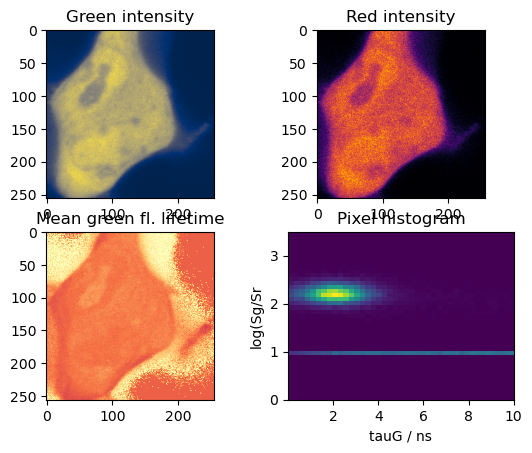

In [67]:
mean_tau_green

array([[[-60.60314757, -69.968409  , -65.06852312, ...,   0.        ,
           0.        ,   0.        ],
        [-63.70403184, -61.16748977, -60.42777429, ...,   0.        ,
           0.        ,   0.        ],
        [-55.41072919, -71.2040123 , -64.28373794, ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [-67.58461232, -62.73440897, -76.13942094, ...,   0.        ,
           0.        ,   0.        ],
        [-57.63085458, -70.08157044, -84.12412907, ...,   0.        ,
           0.        ,   0.        ],
        [-71.81180947, -64.24788885, -69.64703284, ...,   0.        ,
           0.        ,   0.        ]]])

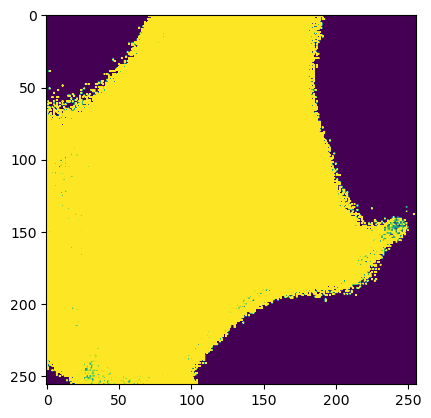

In [5]:
plt.imshow(mean_tau_green.mean(axis=0), vmin=0.0, vmax=3.0)

In [12]:
np.min(mean_tau_green)

nan